# State of the Union Data Analysis

### Import Packages and Set Notebook Settings

In [50]:
#-- Import Packages
#------- General Packages
import os
#------- DA
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#------- Visual
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, Legend
from bokeh.palettes import Category10
from pprint import pprint
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis

#------- Topic Modeling
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

#-- Set Notebook Settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)
output_notebook()
pyLDAvis.enable_notebook()



#-- Instantiate Global Variables
stop_words = set(stopwords.words('english'))
counter = CountVectorizer()
tfidf = TfidfVectorizer()
def color_gen():
    yield from itertools.cycle(Category10[10])

/Users/edwardhulseman/miniforge3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading BokehJS ...

### Read Data

In [51]:
speeches_df = pd.read_excel('SOTU_Speeches.xlsx')
print(speeches_df.shape)


(243, 7)


/Users/edwardhulseman/miniforge3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Clean Data

In [52]:
#-- Remove characters from year
speeches_df['year'] = speeches_df['year'].str.extract('(\d+)', expand=False).astype(int)
#-- Remove "year end" speeches
speeches_df = speeches_df.loc[speeches_df['year_of_presidency'].str.contains('end')==False]
#-- Sort by year/delivery to keep written ones when submitted in multiple forms
speeches_df = speeches_df.sort_values(by=['year', 'delivery'], ascending=[False, False])
speeches_df = speeches_df.groupby(['year', 'president']).first().reset_index()
#-- Create Token Field
speeches_df['speech_tokens'] = speeches_df['speech_text'].apply(lambda x:  word_tokenize(x.lower()))
speeches_df['speech_tokens_stops'] = speeches_df['speech_text'].apply(lambda x: [i for i in word_tokenize(x.lower()) if i not  in stop_words])
speeches_df['speech_stops'] = speeches_df['speech_tokens_stops'].apply(lambda x: " ".join(x))
speeches_df['speech_stops'] = speeches_df['speech_stops'].map(lambda x: re.sub('[,\.!?]', '', x))
#-- CountVectorizer Field
counts = counter.fit_transform(speeches_df['speech_stops'].tolist())
#-- tfidf Field
tfidf = tfidf.fit_transform(speeches_df['speech_stops'].tolist())
#-- Create Number of Tokens
speeches_df['num_tokens'] = speeches_df['speech_tokens'].apply(lambda x: len(x))
#-- Create Number of Unique Tokens
speeches_df['num_unique_tokens'] = speeches_df['speech_tokens'].apply(lambda x: len(list(set(x))))

speeches_df

/Users/edwardhulseman/miniforge3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:2: DeprecationWarning: invalid escape sequence \d
<>:12: DeprecationWarning: invalid escape sequence \.
<>:2: DeprecationWarning: invalid escape sequence \d
<>:12: DeprecationWarning: invalid escape sequence \.
<ipython-input-52-7f09d61913c9>:2: DeprecationWarning: invalid escape sequence \d
  speeches_df['year'] = speeches_df['year'].str.extract('(\d+)', expand=False).astype(int)
<ipython-input-52-7f09d61913c9>:12: DeprecationWarning: invalid escape sequence \.
  speeches_df['speech_stops'] = speeches_df['speech_stops'].map(lambda x: re.sub('[,\.!?]', '', x))


,year,president,years_of_term,delivery,year_of_presidency,speech_url,speech_text,speech_tokens,speech_tokens_stops,speech_stops,num_tokens,num_unique_tokens
0,1790,George Washington,1789-1793,speech,1,https://www.presidency.ucsb.edu/ws/index.php?p...,Fellow-Citizens of the Senate and House of Rep...,"[fellow-citizens, of, the, senate, and, house,...","[fellow-citizens, senate, house, representativ...",fellow-citizens senate house representatives :...,1167,452
1,1791,George Washington,1789-1793,speech,3,https://www.presidency.ucsb.edu/ws/index.php?p...,Fellow-Citizens of the Senate and House of Rep...,"[fellow-citizens, of, the, senate, and, house,...","[fellow-citizens, senate, house, representativ...",fellow-citizens senate house representatives :...,2477,797
2,1792,George Washington,1789-1793,speech,4,https://www.presidency.ucsb.edu/ws/index.php?p...,Fellow-Citizens of the Senate and House of Rep...,"[fellow-citizens, of, the, senate, and, house,...","[fellow-citizens, senate, house, representativ...",fellow-citizens senate house representatives :...,2284,746
3,1793,George Washington,1793-1797,speech,1,https://www.presidency.ucsb.edu/ws/index.php?p...,Fellow-Citizens of the Senate and House of Rep...,"[fellow-citizens, of, the, senate, and, house,...","[fellow-citizens, senate, house, representativ...",fellow-citizens senate house representatives :...,2118,776
4,1794,George Washington,1793-1797,speech,2,https://www.presidency.ucsb.edu/ws/index.php?p...,Fellow-Citizens of the Senate and House of Rep...,"[fellow-citizens, of, the, senate, and, house,...","[fellow-citizens, senate, house, representativ...",fellow-citizens senate house representatives :...,3198,1101
5,1795,George Washington,1793-1797,speech,3,https://www.presidency.ucsb.edu/ws/index.php?p...,Fellow-Citizens of the Senate and House of Rep...,"[fellow-citizens, of, the, senate, and, house,...","[fellow-citizens, senate, house, representativ...",fellow-citizens senate house representatives :...,2151,795
6,1796,George Washington,1793-1797,speech,4,https://www.presidency.ucsb.edu/ws/index.php?p...,Fellow-Citizens of the Senate and House of Rep...,"[fellow-citizens, of, the, senate, and, house,...","[fellow-citizens, senate, house, representativ...",fellow-citizens senate house representatives :...,3093,972
7,1797,John Adams,1797-1801,speech,1,https://www.presidency.ucsb.edu/ws/index.php?p...,Gentlemen of the Senate and Gentlemen of the H...,"[gentlemen, of, the, senate, and, gentlemen, o...","[gentlemen, senate, gentlemen, house, represen...",gentlemen senate gentlemen house representativ...,2234,706
8,1798,John Adams,1797-1801,speech,2,https://www.presidency.ucsb.edu/ws/index.php?p...,Gentlemen of the Senate and Gentlemen of the H...,"[gentlemen, of, the, senate, and, gentlemen, o...","[gentlemen, senate, gentlemen, house, represen...",gentlemen senate gentlemen house representativ...,2364,798
9,1799,John Adams,1797-1801,speech,3,https://www.presidency.ucsb.edu/ws/index.php?p...,Gentlemen of the Senate and Gentlemen of the H...,"[gentlemen, of, the, senate, and, gentlemen, o...","[gentlemen, senate, gentlemen, house, represen...",gentlemen senate gentlemen house representativ...,1623,579


### Word Counts

/Users/edwardhulseman/miniforge3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


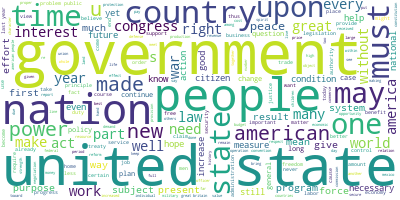

In [53]:
# Join the different processed titles together.
long_string = ','.join(list(speeches_df['speech_stops'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

/Users/edwardhulseman/miniforge3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


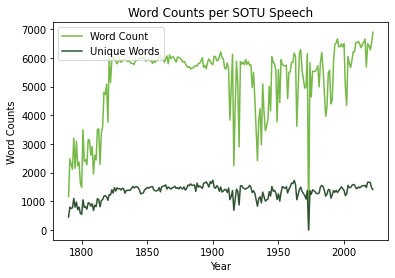

In [54]:
plt.plot(speeches_df['year'], speeches_df['num_tokens'], label='Word Count', color='#76B947')
plt.plot(speeches_df['year'], speeches_df['num_unique_tokens'], label='Unique Words', color='#2F5233')
plt.legend(loc='upper left')
plt.title('Word Counts per SOTU Speech')
plt.xlabel('Year')
plt.ylabel('Word Counts')
plt.show()

### Top Words

/Users/edwardhulseman/miniforge3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


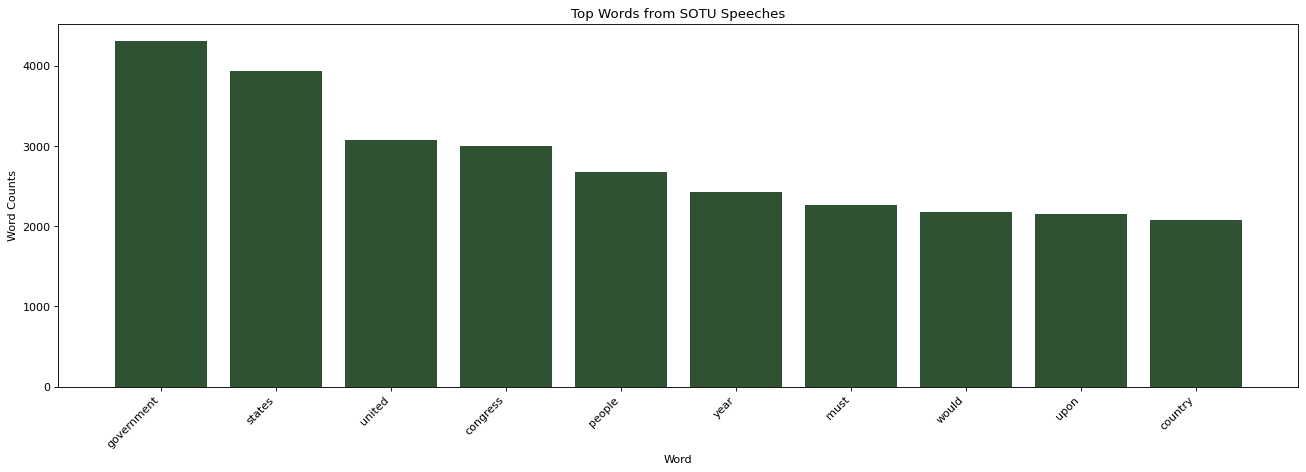

<Figure size 432x288 with 0 Axes>

In [55]:
#-- Data
sum_words = counts.sum(axis=0) 
words_freq = [(word, sum_words[0, idx], idx) for word, idx in     counter.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
top40 = words_freq[0:10]
top_40_df = pd.DataFrame(top40, columns=['Word', 'Counts', 'idx'])

#-- Vis Top Words
plt.figure(figsize=(20, 6), dpi=80)
plt.bar(top_40_df['Word'], top_40_df['Counts'], color='#2F5233')
plt.title('Top Words from SOTU Speeches')
plt.xlabel('Word')
plt.ylabel('Word Counts')
plt.xticks(rotation = 45, ha='right') 
plt.show()
plt.clf()

#-- Top Words Over Time
temporal_top_words = pd.DataFrame()
for i, speech in enumerate(counts.toarray()):
    for j, word in top_40_df.iterrows():
        record = {
            'year': speeches_df.loc[i, 'year'],
            'word': word['Word'],
            'count': speech[word['idx']]
        }
        temporal_top_words = temporal_top_words.append(record, ignore_index=True)
temporal_top_words= temporal_top_words.pivot_table(index='year', columns='word', values='count')


/Users/edwardhulseman/miniforge3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


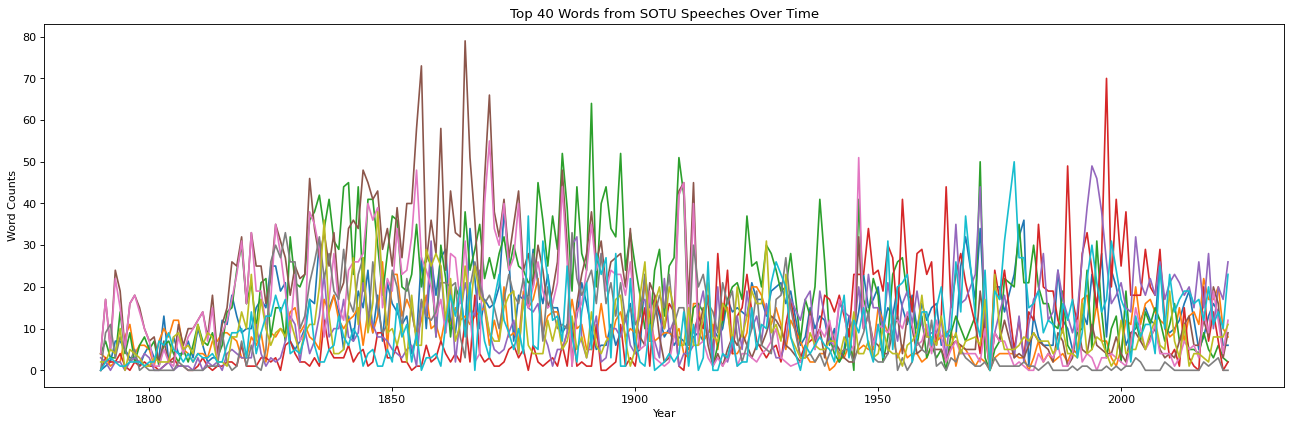

<Figure size 432x288 with 0 Axes>

In [56]:
#-- Vis Top Words
plt.figure(figsize=(20, 6), dpi=80)
for c in temporal_top_words.columns:
    plt.plot(temporal_top_words.index, temporal_top_words[c])
plt.title('Top 40 Words from SOTU Speeches Over Time')
plt.xlabel('Year')
plt.ylabel('Word Counts')
#plt.xticks(rotation = 45, ha='right') 
plt.show()
plt.clf()

### Sentiment Analysis

### Topic Clustering

In [58]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


data = speeches_df['speech_stops'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

/Users/edwardhulseman/miniforge3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['fellow', 'citizens', 'senate', 'house', 'representatives', 'embrace', 'great', 'satisfaction', 'opportunity', 'presents', 'congratulating', 'present', 'favorable', 'prospects', 'public', 'affairs', 'recent', 'accession', 'important', 'state', 'north', 'carolina', 'constitution', 'united', 'states', 'official', 'information', 'received', 'rising', 'credit']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 3), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1)]


In [ ]:
# number of topics
num_topics = 20

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/Users/edwardhulseman/miniforge3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./Models/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
LDAvis_prepared